# Building And Testing A Complete Trading System

In [3]:
import yfinance as yf
import pandas_ta as pa
import plotly.graph_objects as go
import numpy as np

def get_data(symbol: str):
    data = yf.download(tickers=symbol, period='1000d', interval='1d')
    data.reset_index(inplace=True)
    return data
# Get the data
data = get_data('BTC-USD')

[*********************100%%**********************]  1 of 1 completed


## 1- Add rejection signal

In [4]:
def identify_rejection(data):
    # Create a new column for shooting star
    data['rejection'] = data.apply(lambda row: 2 if (
        ( (min(row['Open'], row['Close']) - row['Low']) > (1.5 * abs(row['Close'] - row['Open']))) and 
        (row['High'] - max(row['Close'], row['Open'])) < (0.8 * abs(row['Close'] - row['Open'])) and 
        (abs(row['Open'] - row['Close']) > row['Open'] * 0.001)
    ) else 1 if (
        (row['High'] - max(row['Open'], row['Close'])) > (1.5 * abs(row['Open'] - row['Close'])) and 
        (min(row['Close'], row['Open']) - row['Low']) < (0.8 * abs(row['Open'] - row['Close'])) and 
        (abs(row['Open'] - row['Close']) > row['Open'] * 0.001)
    ) else 0, axis=1)

    return data

data = identify_rejection(data)


In [5]:
data[data["rejection"]!=0]

,Date,Open,High,Low,Close,Adj Close,Volume,rejection
21,2021-02-15,48696.535156,48875.570312,46347.476562,47945.058594,47945.058594,77069903166,2
28,2021-02-22,57532.738281,57533.390625,48967.566406,54207.320312,54207.320312,92052420332,2
34,2021-02-28,46194.015625,46716.429688,43241.617188,45137.769531,45137.769531,53443887451,2
42,2021-03-08,51174.117188,52314.070312,49506.054688,52246.523438,52246.523438,48597428048,2
46,2021-03-12,57821.218750,57996.621094,55376.648438,57332.089844,57332.089844,55689944702,2
...,...,...,...,...,...,...,...,...
966,2023-09-18,26532.994141,27414.734375,26415.515625,26754.281250,26754.281250,15615339655,1
975,2023-09-27,26209.498047,26817.841797,26111.464844,26352.716797,26352.716797,11718380997,1
978,2023-09-30,26911.689453,27091.794922,26888.968750,26967.916016,26967.916016,5331172801,1
990,2023-10-12,26873.292969,26921.439453,26558.320312,26756.798828,26756.798828,9392909295,2


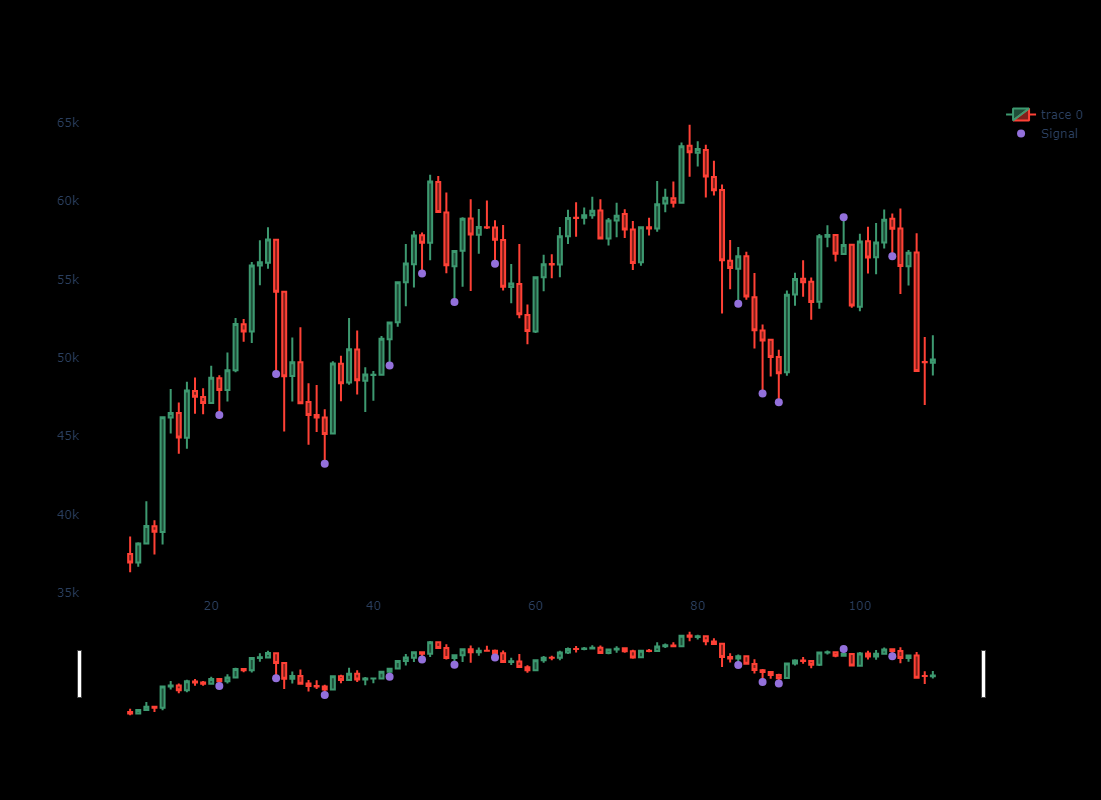

In [6]:
def pointpos(x, xsignal):
    if x[xsignal]==1:
        return x['High']+1e-4
    elif x[xsignal]==2:
        return x['Low']-1e-4
    else:
        return np.nan

def plot_with_signal(dfpl):

    fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                    open=dfpl['Open'],
                    high=dfpl['High'],
                    low=dfpl['Low'],
                    close=dfpl['Close'])])

    fig.update_layout(
        autosize=False,
        width=1000,
        height=800, 
        paper_bgcolor='black',
        plot_bgcolor='black')
    fig.update_xaxes(gridcolor='black')
    fig.update_yaxes(gridcolor='black')
    fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                    marker=dict(size=8, color="MediumPurple"),
                    name="Signal")
    fig.show()

data['pointpos'] = data.apply(lambda row: pointpos(row,"rejection"), axis=1)
plot_with_signal(data[10:110])

## 2- Support and Resistance FUNCTIONS

In [7]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    if ( df1.Low[l-n1:l].min() < df1.Low[l] or
        df1.Low[l+1:l+n2+1].min() < df1.Low[l] ):
        return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    if ( df1.High[l-n1:l].max() > df1.High[l] or
       df1.High[l+1:l+n2+1].max() > df1.High[l] ):
        return 0
    return 1

## 3- Close to resistance and support testing

In [8]:
def closeResistance(l, levels, lim, df):
    if len(levels) == 0:
        return 0
    c1 = abs(df['High'][l] - min(levels, key=lambda x: abs(x - df['High'][l]))) <= lim
    c2 = abs(max(df['Open'][l], df['Close'][l]) - min(levels, key=lambda x: abs(x - df['High'][l]))) <= lim
    c3 = min(df['Open'][l], df['Close'][l]) < min(levels, key=lambda x: abs(x - df['High'][l]))
    c4 = df['Low'][l] < min(levels, key=lambda x: abs(x - df['High'][l]))
    if (c1 or c2) and c3 and c4:
        return min(levels, key=lambda x: abs(x - df['High'][l]))
    else:
        return 0

def closeSupport(l, levels, lim, df):
    if len(levels) == 0:
        return 0
    c1 = abs(df['Low'][l] - min(levels, key=lambda x: abs(x - df['Low'][l]))) <= lim
    c2 = abs(min(df['Open'][l], df['Close'][l]) - min(levels, key=lambda x: abs(x - df['Low'][l]))) <= lim
    c3 = max(df['Open'][l], df['Close'][l]) > min(levels, key=lambda x: abs(x - df['Low'][l]))
    c4 = df['High'][l] > min(levels, key=lambda x: abs(x - df['Low'][l]))
    if (c1 or c2) and c3 and c4:
        return min(levels, key=lambda x: abs(x - df['Low'][l]))
    else:
        return 0

def is_below_resistance(l, level_backCandles, level, df):
    return df.loc[l-level_backCandles:l-1, 'High'].max() < level

def is_above_support(l, level_backCandles, level, df):
    return df.loc[l-level_backCandles:l-1, 'Low'].min() > level

In [9]:
def check_candle_signal(l, n1, n2, levelbackCandles, windowbackCandles, df):
    ss = []
    rr = []
    for subrow in range(l-levelbackCandles, l-n2+1):
        if support(df, subrow, n1, n2):
            ss.append(df.Low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.High[subrow])

    ss.sort() #keep lowest support when popping a level
    for i in range(1,len(ss)):
        if(i>=len(ss)):
            break
        if abs(ss[i]-ss[i-1])/ss[i]<=0.001: # merging close distance levels
            ss.pop(i)

    rr.sort(reverse=True) # keep highest resistance when popping one
    for i in range(1,len(rr)):
        if(i>=len(rr)):
            break
        if abs(rr[i]-rr[i-1])/rr[i]<=0.001: # merging close distance levels
            rr.pop(i)

    #----------------------------------------------------------------------
    # joined levels
    rrss = rr+ss
    rrss.sort()
    for i in range(1,len(rrss)):
        if(i>=len(rrss)):
            break
        if abs(rrss[i]-rrss[i-1])/rrss[i]<=0.001: # merging close distance levels
            rrss.pop(i)
    cR = closeResistance(l, rrss, df.Close[l]*0.003, df)
    cS = closeSupport(l, rrss, df.Close[l]*0.003, df)
    #----------------------------------------------------------------------

    # cR = closeResistance(l, rr, 150e-5, df)
    # cS = closeSupport(l, ss, 150e-5, df)
    #print(rrss,df.Close*0.002)
    if (df.rejection[l] == 1 and cR and is_below_resistance(l,windowbackCandles,cR, df)):
        return 1
    elif(df.rejection[l] == 2 and cS and is_above_support(l,windowbackCandles,cS, df)):
        return 2
    else:
        return 0

In [10]:
from tqdm import tqdm

n1 = 8
n2 = 8
levelbackCandles = 60
windowbackCandles = n2

signal = [0 for i in range(len(data))]

for row in tqdm(range(levelbackCandles+n1, len(data)-n2)):
    signal[row] = check_candle_signal(row, n1, n2, levelbackCandles, windowbackCandles, data)

data["signal"] = signal

  0%|          | 0/924 [00:00<?, ?it/s]

100%|██████████| 924/924 [00:07<00:00, 121.24it/s]


In [11]:
data[data["signal"]!=0]

,Date,Open,High,Low,Close,Adj Close,Volume,rejection,pointpos,signal
220,2021-09-02,48807.847656,50343.421875,48652.320312,49327.722656,49327.722656,39508070319,1,50343.421975,1
381,2022-02-10,44347.800781,45661.171875,43402.808594,43565.113281,43565.113281,32142048537,1,45661.171975,1
424,2022-03-25,43964.546875,44999.492188,43706.285156,44348.730469,44348.730469,30574413034,1,44999.492287,1
626,2022-10-13,19156.966797,19453.328125,18319.822266,19382.904297,19382.904297,44219840004,2,18319.822166,2
704,2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,16602.585938,15929162910,2,16408.474509,2
850,2023-05-25,26329.460938,26591.519531,25890.593750,26476.207031,26476.207031,13851122697,2,25890.593650,2
892,2023-07-06,30507.150391,31460.052734,29892.226562,29909.337891,29909.337891,21129219509,1,31460.052834,1


In [12]:
data['pointpos'] = data.apply(lambda row: pointpos(row,"signal"), axis=1)
plot_with_signal(data[500:750])

## 4- Backtesting

In [13]:
data.set_index("Date", inplace=True)

In [14]:
data

,Open,High,Low,Close,Adj Close,Volume,rejection,pointpos,signal
Date,,,,,,,,,
2021-01-25,32285.798828,34802.742188,32087.787109,32366.392578,32366.392578,59897054838,0,NaN,0
2021-01-26,32358.613281,32794.550781,31030.265625,32569.849609,32569.849609,60255421470,0,NaN,0
2021-01-27,32564.029297,32564.029297,29367.138672,30432.546875,30432.546875,62576762015,0,NaN,0
2021-01-28,30441.041016,33858.312500,30023.207031,33466.097656,33466.097656,76517157706,0,NaN,0
2021-01-29,34318.671875,38406.261719,32064.814453,34316.386719,34316.386719,117894572511,0,NaN,0
...,...,...,...,...,...,...,...,...,...
2023-10-17,28522.097656,28618.751953,28110.185547,28415.748047,28415.748047,14872527508,0,NaN,0
2023-10-18,28413.531250,28889.009766,28174.251953,28328.341797,28328.341797,12724128586,0,NaN,0
2023-10-19,28332.416016,28892.474609,28177.988281,28719.806641,28719.806641,14448058195,0,NaN,0


In [15]:
data['ATR'] = pa.atr(high=data.High, low=data.Low, close=data.Close, length=14)
data['RSI'] = pa.rsi(data.Close, length=5)

In [16]:
def SIGNAL():
    return data.signal

In [17]:
#A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().
#Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient, 
#vectorized manner whatever indicators and signals the strategy depends on.
#Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row), 
#simulating the incremental availability of each new full candlestick bar.

#Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the
#next candle's open (or the current candle's close if trade_on_close=True). 
#If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin 
#with more fine-grained (e.g. hourly) data.

### 4.1- Using Fixed SL and TP rules

In [18]:
# Trader fixed SL and TP
from backtesting import Strategy, Backtest
class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)
        self.ratio = 2
        self.risk_perc = 0.1

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - self.data.Close[-1]*self.risk_perc
            tp1 = self.data.Close[-1] + (self.data.Close[-1]*self.risk_perc)*self.ratio
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + self.data.Close[-1]*self.risk_perc
            tp1 = self.data.Close[-1] - (self.data.Close[-1]*self.risk_perc)*self.ratio
            self.sell(sl=sl1, tp=tp1)
bt = Backtest(data, MyCandlesStrat, cash=100_000, commission=.000)
stat = bt.run()
stat

f:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Start                     2021-01-25 00:00:00
End                       2023-10-21 00:00:00
Duration                    999 days 00:00:00
Exposure Time [%]                        18.1
Equity Final [$]                160010.730469
Equity Peak [$]                 160010.730469
Return [%]                           60.01073
Buy & Hold Return [%]               -7.834244
Return (Ann.) [%]                   18.717413
Volatility (Ann.) [%]               26.194894
Sharpe Ratio                         0.714544
Sortino Ratio                        1.392739
Calmar Ratio                         0.752692
Max. Drawdown [%]                  -24.867308
Avg. Drawdown [%]                   -5.295798
Max. Drawdown Duration      214 days 00:00:00
Avg. Drawdown Duration       31 days 00:00:00
# Trades                                    6
Win Rate [%]                        66.666667
Best Trade [%]                      20.011045
Worst Trade [%]                    -10.088094
Avg. Trade [%]                    

In [16]:
bt.plot()

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1307', ...)

### 4.2- Using the RSI for Exit Signals

In [52]:
from backtesting import Strategy, Backtest

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)
        self.ratio = 2
        self.risk_perc = 0.1

    def next(self):
        super().next()
        
        if len(self.trades)>0:
            if self.trades[-1].is_long and self.data.RSI[-1]>=80:
                self.trades[-1].close()
            elif self.trades[-1].is_short and self.data.RSI[-1]<=20:
                self.trades[-1].close()

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - self.data.Close[-1]*self.risk_perc
            tp1 = self.data.Close[-1] + (self.data.Close[-1]*self.risk_perc)*self.ratio
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.Close[-1] + self.data.Close[-1]*self.risk_perc
            tp1 = self.data.Close[-1] - (self.data.Close[-1]*self.risk_perc)*self.ratio
            self.sell(sl=sl1, tp=tp1)
bt = Backtest(data, MyCandlesStrat, cash=100_000, commission=.000)
stat = bt.run()
stat

Start                     2021-01-24 00:00:00
End                       2023-10-20 00:00:00
Duration                    999 days 00:00:00
Exposure Time [%]                        14.4
Equity Final [$]                179547.597656
Equity Peak [$]                 179547.597656
Return [%]                          79.547598
Buy & Hold Return [%]               -8.648288
Return (Ann.) [%]                   23.815653
Volatility (Ann.) [%]                19.53769
Sharpe Ratio                          1.21896
Sortino Ratio                        3.299022
Calmar Ratio                         2.606954
Max. Drawdown [%]                   -9.135433
Avg. Drawdown [%]                   -2.203931
Max. Drawdown Duration      189 days 00:00:00
Avg. Drawdown Duration       15 days 00:00:00
# Trades                                    7
Win Rate [%]                            100.0
Best Trade [%]                      17.469269
Worst Trade [%]                      2.953071
Avg. Trade [%]                    

In [23]:
bt.plot()

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1637', ...)

### 4.3- ATR based SL and TP

In [59]:
# ATR related SL and TP
from backtesting import Strategy, Backtest
import numpy as np

class MyCandlesStrat(Strategy): 
    atr_f = 0.5
    ratio_f = 1.5
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - self.data.ATR[-1]/self.atr_f
            tp1 = self.data.Close[-1] + self.data.ATR[-1]*self.ratio_f/self.atr_f
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + self.data.ATR[-1]/self.atr_f
            tp1 = self.data.Close[-1] - self.data.ATR[-1]*self.ratio_f/self.atr_f
            self.sell(sl=sl1, tp=tp1)
bt = Backtest(data, MyCandlesStrat, cash=100_000, commission=.000)
stat = bt.run()
stat

Start                     2021-01-24 00:00:00
End                       2023-10-20 00:00:00
Duration                    999 days 00:00:00
Exposure Time [%]                         9.5
Equity Final [$]                119953.300358
Equity Peak [$]                 143069.498096
Return [%]                            19.9533
Buy & Hold Return [%]               -8.648288
Return (Ann.) [%]                    6.865975
Volatility (Ann.) [%]               15.570828
Sharpe Ratio                         0.440951
Sortino Ratio                        0.882598
Calmar Ratio                         0.424945
Max. Drawdown [%]                  -16.157321
Avg. Drawdown [%]                   -3.905962
Max. Drawdown Duration      215 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                    7
Win Rate [%]                        57.142857
Best Trade [%]                      13.404692
Worst Trade [%]                     -7.526474
Avg. Trade [%]                    

In [60]:
bt.plot()

f:\Python\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

f:\Python\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p2201', ...)

### 4.4- Trail Stop

In [67]:
#fixed distance Trailing SL
from backtesting import Strategy, Backtest

class MyCandlesStrat(Strategy):
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        sltr=self.data.Close[-1]*0.02

        for trade in self.trades: 
            if trade.is_long: 
                trade.sl = max(trade.sl or -np.inf, self.data.Close[-1] - sltr)
            else:
                trade.sl = min(trade.sl or np.inf, self.data.Close[-1] + sltr) 
        
        if self.signal1==2 and len(self.trades)==0: 
            sl1 = self.data.Close[-1] - sltr
            self.buy(sl=sl1)
        elif self.signal1==1 and len(self.trades)==0: 
            sl1 = self.data.Close[-1] + sltr
            self.sell(sl=sl1)


bt = Backtest(data, MyCandlesStrat, cash=100_000, commission=.000)
stat = bt.run()
stat

Start                     2021-01-24 00:00:00
End                       2023-10-20 00:00:00
Duration                    999 days 00:00:00
Exposure Time [%]                         4.2
Equity Final [$]                118635.360469
Equity Peak [$]                 123280.318594
Return [%]                           18.63536
Buy & Hold Return [%]               -8.648288
Return (Ann.) [%]                    6.435907
Volatility (Ann.) [%]                7.235593
Sharpe Ratio                         0.889479
Sortino Ratio                        2.294279
Calmar Ratio                         1.287354
Max. Drawdown [%]                    -4.99933
Avg. Drawdown [%]                   -2.600717
Max. Drawdown Duration      332 days 00:00:00
Avg. Drawdown Duration      155 days 00:00:00
# Trades                                    7
Win Rate [%]                        42.857143
Best Trade [%]                      24.949697
Worst Trade [%]                     -2.081687
Avg. Trade [%]                    

In [64]:
bt.plot()

f:\Python\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

f:\Python\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p2561', ...)

In [73]:
#ATR based Trailing Stop
from backtesting import Strategy, Backtest

class MyCandlesStrat(Strategy):
    atr_f = 0.6
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)
        self.sltr=0

    def next(self):
        super().next()
        
        for trade in self.trades: 
            if trade.is_long: 
                trade.sl = max(trade.sl or -np.inf, self.data.Close[-1] - self.sltr)
            else:
                trade.sl = min(trade.sl or np.inf, self.data.Close[-1] + self.sltr)

        if self.signal1==2 and len(self.trades)==0: 
            self.sltr=self.data.ATR[-1]/self.atr_f
            sl1 = self.data.Close[-1] - self.data.ATR[-1]/self.atr_f
            self.buy(sl=sl1)
        elif self.signal1==1 and len(self.trades)==0: 
            self.sltr=self.data.ATR[-1]/self.atr_f
            sl1 = self.data.Close[-1] + self.data.ATR[-1]/self.atr_f
            self.sell(sl=sl1)
bt = Backtest(data, MyCandlesStrat, cash=100_000, commission=.000)
stat = bt.run()
stat

Start                     2021-01-24 00:00:00
End                       2023-10-20 00:00:00
Duration                    999 days 00:00:00
Exposure Time [%]                         8.5
Equity Final [$]                114399.742824
Equity Peak [$]                 124148.873143
Return [%]                          14.399743
Buy & Hold Return [%]               -8.648288
Return (Ann.) [%]                    5.032848
Volatility (Ann.) [%]               12.076801
Sharpe Ratio                         0.416737
Sortino Ratio                        0.726958
Calmar Ratio                         0.399561
Max. Drawdown [%]                  -12.595935
Avg. Drawdown [%]                   -5.345708
Max. Drawdown Duration      325 days 00:00:00
Avg. Drawdown Duration      130 days 00:00:00
# Trades                                    7
Win Rate [%]                        57.142857
Best Trade [%]                      24.433671
Worst Trade [%]                     -7.018164
Avg. Trade [%]                    

## 5- Lot sizing and trade management

In [49]:
class MyCandlesStrat(Strategy):
    lotsize = 1 
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)
        self.ratio = 1.
        self.risk_perc = 0.1

    def next(self):
        super().next() 
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - self.data.Close[-1]*self.risk_perc
            tp1 = self.data.Close[-1] + (self.data.Close[-1]*self.risk_perc)*self.ratio*0.8
            tp2 = self.data.Close[-1] + (self.data.Close[-1]*self.risk_perc)*self.ratio*1.2
            self.buy(sl=sl1, tp=tp1, size=self.lotsize)
            self.buy(sl=sl1, tp=tp2, size=self.lotsize)
        elif self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.Close[-1] + self.data.Close[-1]*self.risk_perc
            tp1 = self.data.Close[-1] - (self.data.Close[-1]*self.risk_perc)*self.ratio*0.8
            tp2 = self.data.Close[-1] - (self.data.Close[-1]*self.risk_perc)*self.ratio*1.2
            self.sell(sl=sl1, tp=tp1, size=self.lotsize)
            self.sell(sl=sl1, tp=tp2, size=self.lotsize)
bt = Backtest(data, MyCandlesStrat, cash=100_000, margin=1/1, commission=.02)
stat = bt.run()
stat

Start                     2021-01-25 00:00:00
End                       2023-10-21 00:00:00
Duration                    999 days 00:00:00
Exposure Time [%]                        14.8
Equity Final [$]                127516.368555
Equity Peak [$]                 127516.368555
Return [%]                          27.516369
Buy & Hold Return [%]               -7.834244
Return (Ann.) [%]                    9.277705
Volatility (Ann.) [%]               11.232617
Sharpe Ratio                         0.825961
Sortino Ratio                         1.73729
Calmar Ratio                         1.273648
Max. Drawdown [%]                   -7.284353
Avg. Drawdown [%]                    -2.22581
Max. Drawdown Duration      204 days 00:00:00
Avg. Drawdown Duration       21 days 00:00:00
# Trades                                   13
Win Rate [%]                        92.307692
Best Trade [%]                      10.216479
Worst Trade [%]                    -11.763017
Avg. Trade [%]                    